# KMEANS, DBSCAN和AP聚类
DBSCAN原理：https://www.youtube.com/watch?v=RDZUdRSDOok

再回到聚类，聚类有两类：分层和分区

分层算法递归地将数据集分割成更小的子集，直到子集仅包含一项。 这一过程可以用树状图来表示。 它可以从叶子到根（凝聚方法）或从根到叶子（分裂方法）构建。 在层次聚类中，不必指定簇的数量，但必须定义分裂/合并过程的终止条件。

分区算法根据给定的标准将数据集划分为多个子集（簇）。 对于某些算法，簇的数量必须预先定义（例如 K-Means），而对于某些算法则不需要（DBSCAN）。 在运行算法之前定义簇的数量通常需要特定的领域知识，这在许多应用程序中通常具有挑战性（甚至是不可能的）。 这导致了许多启发式方法和简化方法的发展

本文kaggle链接：https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap

## 阅读数据


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.5.3
numpy version: 1.23.5
seaborn version: 0.12.2


In [2]:
import os
for dirname, _, filenames in os.walk('.\datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# 任何在这个工程文件夹的datasets子文件夹中的文件将被输出

#忽略警告
import warnings
warnings.filterwarnings('ignore')

.\datasets\iris.csv
.\datasets\Live.csv
.\datasets\Mall_Customers.csv


In [7]:
mall_data = pd.read_csv('.\datasets\Mall_Customers.csv')

print(mall_data.shape)
print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

(200, 5)
There are 200 rows and 5 columns in our dataset.


In [8]:
mall_data.head

<bound method NDFrame.head of      CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]>

In [16]:
mall_data.info()
mall_data.isnull().sum()
# 数据集完整，注意Gender代表性别，需要进行转化
# 由于数据集完整，不需要进行删除操作

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [14]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
152,153,Female,44,78,20
40,41,Female,65,38,35
100,101,Female,23,62,41
108,109,Male,68,63,43
2,3,Female,20,16,6
81,82,Male,38,54,55
132,133,Female,25,72,34
39,40,Female,20,37,75
155,156,Female,27,78,89
56,57,Female,51,44,50


In [15]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### 性别信息：是否要二进制？
这里我们有非数值类型的gender信息，一个简单的想法是将其转换成0-1编码，但是作者并不推荐这么做：

There is one binary, categorical column: gender. You may be tempted to one-hot encode it for the clustering. It is:

1. technically possible
2. theoretically not forbidden
3. practically not recommended

However, it is not recommended and nicely explained on the IBM support site：https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided


## 数据分析
现在主要是做一些分布上和相关性上的工作

### 分布


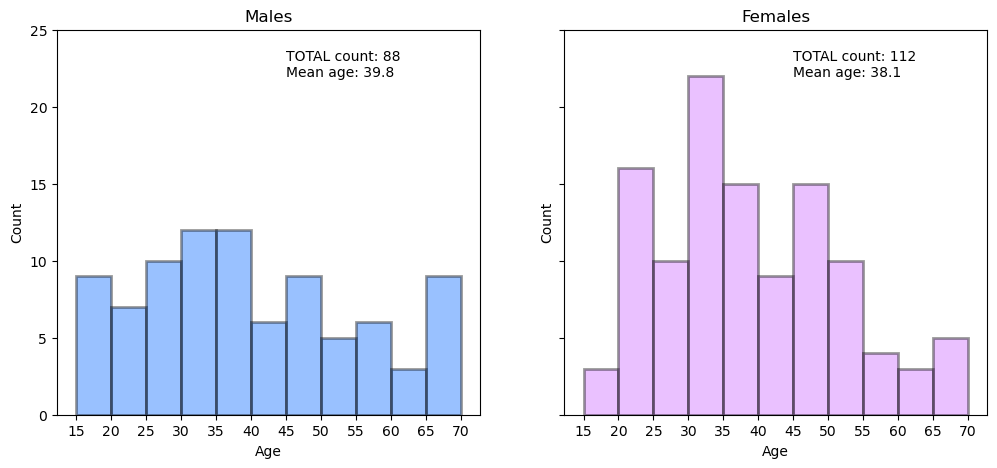

In [23]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
#使用seaborn的distplot绘制直方图，kde=False只绘制直方柱，k表示边缘颜色为黑色

ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

### Kolmogorov-Smirnov检验
https://www.bilibili.com/video/BV1gY4y1e79V/?spm_id_from=333.337.search-card.all.click&vd_source=4bccf0bae6366f8cf252ccd21d3e6844

原理是假设两个样本来自同一分布，求出P-value，其值越小，则能说明其来自不同的分布，值越大，则说明来自同一分布的概率较大

一般来说，p值若>0.05，接受原假设即样本来自的总体分布服从某指定分布无显著性差异

In [26]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


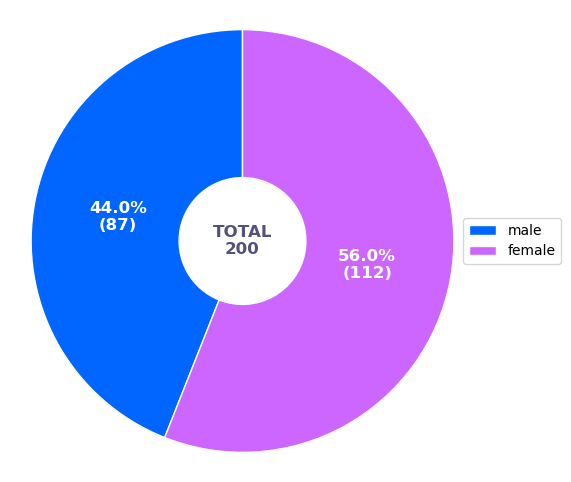

In [27]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

可以看到，男性人数比女性人数稍多

接下来我们看看两种群体的收入和箱线图

四分位数的计算：https://www.bilibili.com/video/BV1P34y1U7jB/?spm_id_from=333.788.recommend_more_video.0&vd_source=4bccf0bae6366f8cf252ccd21d3e6844

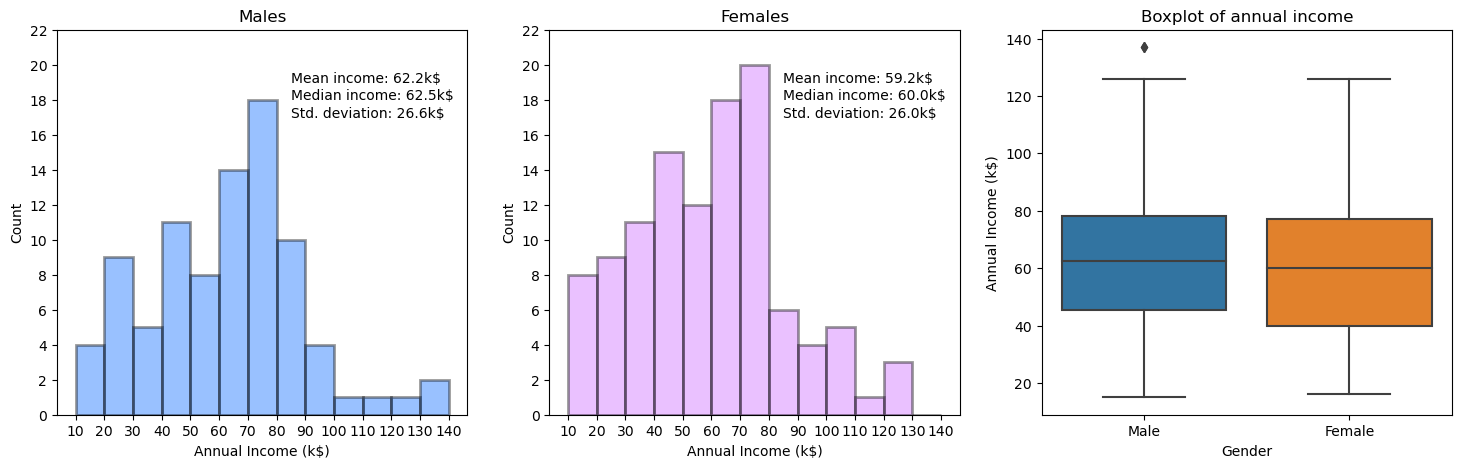

Kolgomorov-Smirnov test p-value: 0.78


In [29]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()


print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

男性平均收入高于女性（62.2 k$ vs. 59.2k\$）。 此外，男性顾客的收入中位数（6.25 万美元）也高于女性顾客（6 万美元）。 两组的标准差相似。 年收入14万美元左右的男性群体中有一个异常值。 K-S检验显示这两组没有统计学差异。

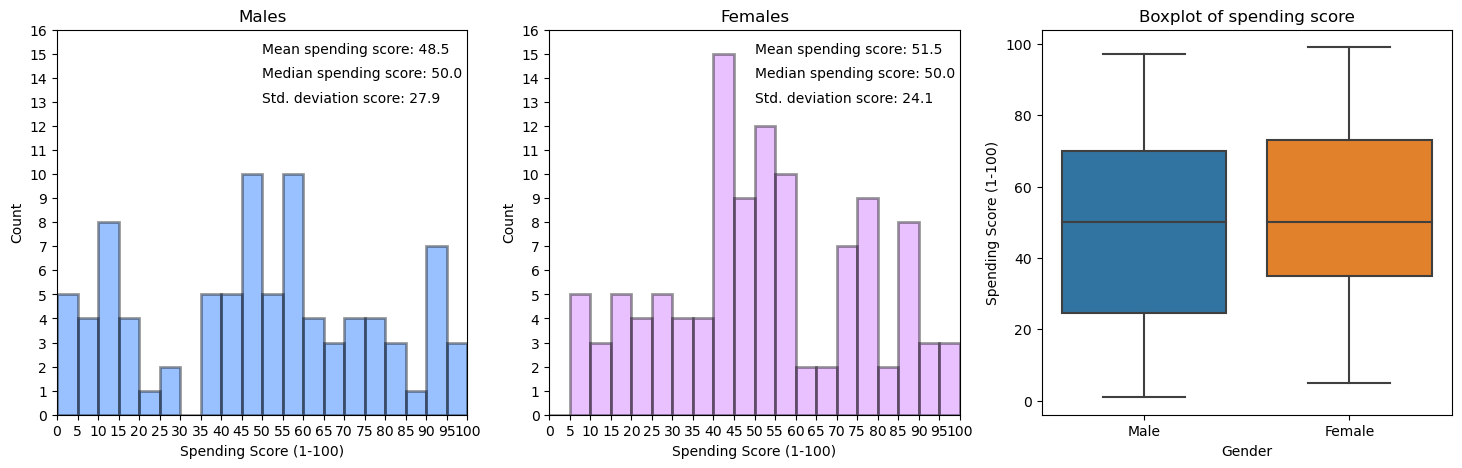

Kolgomorov-Smirnov test p-value: 0.29


In [31]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))


女性的平均支出得分 (51.5) 高于男性 (48.5)。 K-S 检验 p 值表明没有证据拒绝原假设，但证据并不像之前的比较中那么有力。 接下来将计算所有年龄段的收入中位数。为了方便理解，将代码进行分解

In [42]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
# 前文中age_bins = range(15,75,5)
medians_by_age_group.head()

CustomerID   Age  Annual Income (k$)  Spending Score (1-100)
Gender Age                                                                   
Female (15, 20]       112.0  19.0                63.0                    50.0
       (20, 25]        46.0  23.0                39.0                    65.0
       (25, 30]       139.5  29.0                74.5                    73.0
       (30, 35]       126.0  32.0                70.0                    69.0
       (35, 40]       138.5  38.0                73.5                    41.0

In [43]:
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.head()

CustomerID   Age  Annual Income (k$)  Spending Score (1-100)
Gender Age_group                                                              
Female (15, 20]        112.0  19.0                63.0                    50.0
       (20, 25]         46.0  23.0                39.0                    65.0
       (25, 30]        139.5  29.0                74.5                    73.0
       (30, 35]        126.0  32.0                70.0                    69.0
       (35, 40]        138.5  38.0                73.5                    41.0

In [44]:
medians_by_age_group.reset_index(inplace=True)
medians_by_age_group.head()

,Gender,Age_group,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,Female,"(15, 20]",112.0,19.0,63.0,50.0
1,Female,"(20, 25]",46.0,23.0,39.0,65.0
2,Female,"(25, 30]",139.5,29.0,74.5,73.0
3,Female,"(30, 35]",126.0,32.0,70.0,69.0
4,Female,"(35, 40]",138.5,38.0,73.5,41.0


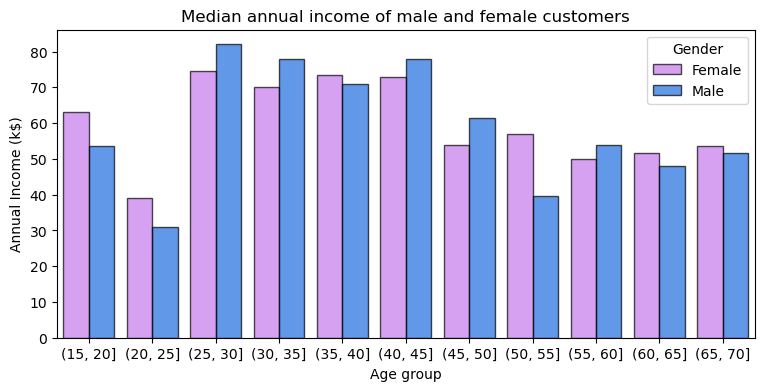

In [57]:
fig, ax = plt.subplots(figsize=(9,4))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

上面的条形图显示，最富有的客户年龄在 25-45 岁之间。 女性和男性之间最大的差异体现在 25-30 岁（男性更富有）和 50-55 岁（女性更富有）的年龄段。

## 相关性分析

Pearson相关系数：https://www.zhihu.com/question/19734616/answer/117730676